# Imports

In [67]:
from gridworld_project import GridWorld, generate_a_grid, generate_a_grid_withwalls
import gridrender as gui
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import time
import numbers
import scipy
from scipy import stats
from tdqm import tdqm

ModuleNotFoundError: No module named 'tdqm'

# Tools

In [55]:
def xlogx(x):
    if x == 0:
        return 0
    else:
        return x * np.log(x)
    
def matrixB(env, sampler, tests = False):
    eps = .001
    
    #calcul des fréquences de transition
    B = []
    keeps = []
    for strt in range(env.n_states): 
        actions = env.state_actions[strt]
        #print(strt,actions)
        tmpBi = np.zeros((len(actions),env.n_states))
        
        #on fait comme si les états 0 étaient absorbants, ce que l on veut qu ils soient
        r, c = env.state2coord[strt]
        if env.grid[r][c] == 0:
            for a in range(len(actions)):
                tmpBi[a][strt] = 100
        else:       
            for itr in range(sampler):
                for a in range(len(actions)):
                    nxt = env.step(strt,actions[a])[0]
                    #print(nxt)
                    tmpBi[a][nxt] += 1
        #
        tmpBisum = np.sum(tmpBi, axis = 0)
        #print("+",tmpBisum)
        zrs = np.argwhere(tmpBisum == 0).transpose()[0]
        kps = np.argwhere(tmpBisum != 0).transpose()[0]
        #print(tmpBi)
        #print(zrs)
        tmpBi = np.delete(tmpBi, zrs.tolist(), 1)
        #
        B.append(tmpBi)
        keeps.append(kps)

    #rajout des epsilons            
    for strt in range(env.n_states):
        for a in range(len(B[strt])):
            for nxt in range(len(B[strt][a])):    
                if B[strt][a][nxt] == 0:
                    B[strt][a][nxt] = eps
    
    #renormalisation                    
    for strt in range(env.n_states):
        for a in range(len(B[strt])):
            B[strt][a] = B[strt][a] / np.sum(B[strt][a])
                     
    #B[etat de depart][action][etat d arrivee]
    return [B, keeps]

def hentropy(B, env):
    hent = []
    for stt in range(env.n_states):
        henti = np.zeros(len(B[stt]))
        for a in range(len(B[stt])):
            henti[a] = np.sum([xlogx(B[stt][a][j]) for j in range(len(B[stt][a]))])
        hent.append(henti)
    return hent

def ltilde(stt,a,scale,env):
    r, c = env.state2coord[stt]
    if isinstance(env.grid[r][c], numbers.Number):
        #return abs(env.grid[r][c]) * scale
        return env.grid[r][c] * scale
    else:
        return 0

def embedding(env, sampler, scale = 3, tests = False):
    [B, keeps] = matrixB(env, sampler)
    #pB = np.linalg.pinv(B)
    xlist = []
    ylist = []
    qlist = []
    xtildelist = []
    hent = hentropy(B, env)
    
    for stt in range(env.n_states):
        pBi = np.linalg.pinv(B[stt], rcond=1e-30)
        y = ltilde(stt,0,scale,env)*np.ones(len(B[stt])) - hent[stt]
        xtilde = -np.dot(pBi,y)
        q = - np.log(np.sum(np.exp(xtilde)))
        #x = q*np.ones(env.n_states) + xtilde
        #print('~',xtilde)
        x = q*np.ones(B[stt].shape[1]) + xtilde
        xlist.append(x)
        ylist.append(y)
        qlist.append(q)
        #print('q',q)
        xtildelist.append(xtilde)
    #print(qlist)
    
    #test des proprietes 38 et 39 et de la positivité de q
    if tests == True:
        bug1, bug2, bug3 = False, False, False
        for stt in range(env.n_states):
            if abs(np.sum(np.exp(xlist[stt])) - 1) > .0001:
                bug1 = True
                print(stt)
            if np.linalg.norm(qlist[stt]*np.ones(B[stt].shape[0]) - np.dot(B[stt],xlist[stt]) - ylist[stt]) > .0001:
                bug2 = True
                print(stt, np.linalg.norm(qlist[stt]*np.ones(B[stt].shape[0]) - np.dot(B[stt],xlist[stt]) - ylist[stt]))
            if qlist[stt] < 0:
                bug3 = True
        print(bug1, bug2, bug3)
    
    pbarre = np.zeros((env.n_states, env.n_states))
    for stt in range(env.n_states):
        #mef : on passe par les keeps car on a tej les non voisins
        for nxtnumber in range(len(keeps[stt])):
            pbarre[stt][keeps[stt][nxtnumber]] = np.exp(xlist[stt][nxtnumber])
    
    return [qlist,pbarre]

#np.log(B[i][a][j]) - xlist[i][j] pas dépendant de i ?

def LPrelax(env, sampler = 1000, verbose = False):
    t0 = time.clock()
    [qlist,pbarre] = embedding(env, sampler, 2.25)
    G = np.diag(np.exp(-np.array(qlist)))
    P = pbarre
#    ancienne méthode, vaseuse au demeurant
#    [eigenvalues, eigenvectors] = np.linalg.eig(np.dot(G,P))
#    eigenvectors = eigenvectors.transpose()
#    oneindices = np.argwhere(eigenvalues > .9999).transpose()[0]
#    onevectors = np.array([eigenvectors[i] for i in oneindices])
#    return onevectors
    z = np.ones(env.n_states)
    zold = np.ones(env.n_states)*100
    while np.linalg.norm(zold-z)>1e-30:
        zold = z
        z = np.dot(np.dot(G,P),z)
    v = -np.log(z)
    t1 = time.clock()
    if verbose == True:
        print("time : ",t1-t0)
    return v

def display(env, v, weights = False):
    wght = np.zeros((len(env.grid[0]),len(env.grid)))
    dspl = np.zeros((len(env.grid[0]),len(env.grid)))
    for r in range(len(env.grid)):
        for c in range(len(env.grid[0])):
            if env.grid[r][c] == 'x':
                dspl[r][c] = -1
                wght[r][c] = -1
    for stt in range(env.n_states):
        r, c = env.state2coord[stt]
        dspl[r][c] = v[stt]
        wght[r][c] = env.grid[r][c]
    if weights == True:
        plt.matshow(wght)
        plt.colorbar()
    plt.matshow(dspl)
    plt.colorbar()
    plt.figure(figsize=(10,10))
    plt.show()
    return dspl

def valnumber(env, stt):
    r, c = env.state2coord[stt]
    return env.grid[r][c]

def neighbours(env, stt):
    #print(stt)
    r, c = env.state2coord[stt]
    out = []
    actions = env.state_actions[stt]
    if 0 in actions:
        rightstt = env.coord2state[r][c+1]
        out.append(rightstt)
    if 2 in actions:
        lefttstt = env.coord2state[r][c-1]
        out.append(lefttstt)
    if 1 in actions:
        downstt = env.coord2state[r+1][c]
        out.append(downstt)
    if 3 in actions:
        upstt = env.coord2state[r-1][c]
        out.append(upstt)
    return out

def merge(list1,list2):
    #merge two list of {two element lists} in a way such that the first element of each couple appears only once, choosing the one that correspond to the lowest second element
    #merge([[1,2],[2,3]] , [[2,1]]) = [[1,2],[2,1]]
    for cpl in list2:
        if cpl[0] in np.array(list1)[:,0]:
            index = np.argwhere(np.array(list1)[:,0]==cpl[0]).transpose()[0][0]
            if cpl[1] < list1[index][1]:
                list1[index][1] = cpl[1]
        else:
            list1.append(cpl)
    return list1
    
def dijkstra(env):
    
    abs_stt = []
    for stt in range(env.n_states):
        r, c = env.state2coord[stt]
        if env.grid[r][c] == 0:
            abs_stt.append(stt)
            
    allprices = []
    
    for final_stt in abs_stt:
        #boucler sur i a la place de 0
        #final_stt = abs_stt[0]
        
        prices = 100000 * np.ones(env.n_states)
        prices[final_stt] = 0
        candidates = neighbours(env, final_stt)
        knownstates = [final_stt]
        
        for index in range(len(candidates)):
           prices[candidates[index]] = min(prices[candidates[index]], prices[final_stt]+valnumber(env, candidates[index]))
    
        while len(candidates) != 0:
            #print('c1',len(candidates))
            #chooses the element in candidates corresponding to the lowest price
            #print('c',candidates)
            selected = candidates[np.argmin(prices[np.array(candidates)])]
            if selected in knownstates:
                print('error')
                print('selected',selected)
                break
            #print(selected)
            knownstates.append(selected)
            #print('k', knownstates)
            candidates.remove(selected)
            #print('c2',len(candidates))
            
            #print(selected)
            selectednghbrs = neighbours(env, selected)
            #print(selectednghbrs)
            
            for index in range(len(selectednghbrs)):
                prices[selectednghbrs[index]] = min(prices[selectednghbrs[index]], prices[selected]
                                                    +valnumber(env, selectednghbrs[index]))
            candidates = list(set(candidates)|set(selectednghbrs))
            candidates = list(set(candidates)-set(knownstates))
            
        allprices.append(prices)
        
    mergeprices = np.min(np.array(allprices),axis=0)
    
    return mergeprices

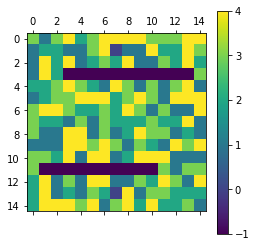

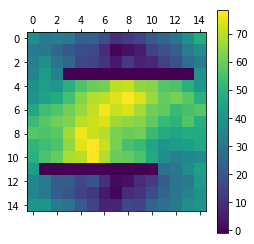

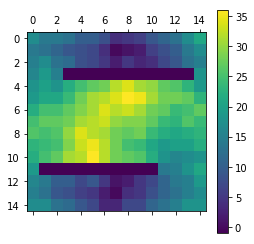

array([[17., 14., 14., 13., 10., 10.,  8.,  4.,  5.,  6.,  9., 11., 13.,
        17., 21.],
       [14., 13., 11.,  9.,  8.,  7.,  4.,  0.,  1.,  2.,  6.,  8., 10.,
        14., 17.],
       [15., 17., 13., 12.,  8.,  7.,  5.,  2.,  5.,  3.,  4.,  7.,  9.,
        13., 15.],
       [16., 19., 15., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., 18.],
       [18., 20., 18., 22., 25., 27., 28., 32., 34., 31., 30., 27., 26.,
        23., 19.],
       [19., 21., 21., 24., 28., 31., 32., 34., 36., 35., 31., 28., 28.,
        27., 23.],
       [22., 25., 25., 27., 29., 31., 34., 32., 33., 31., 28., 27., 24.,
        25., 27.],
       [25., 27., 27., 28., 31., 32., 33., 30., 29., 29., 27., 24., 23.,
        26., 24.],
       [26., 25., 26., 30., 34., 32., 31., 28., 27., 28., 24., 22., 21.,
        22., 23.],
       [23., 24., 25., 29., 33., 35., 32., 28., 25., 24., 21., 19., 20.,
        20., 22.],
       [22., 25., 27., 31., 32., 36., 32., 28., 27., 26., 22., 18., 16.,
       

In [32]:
env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(15,5))
mergeprices = dijkstra(env)
v = LPrelax(env)   
display(env, v, True)
display(env, mergeprices)

# First study : width impact, noise 5

In [40]:
#env = GridWorld(gamma=0.95, grid=generate_a_grid(20,2))
env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(10,5))

n_samples = 5

values_dijkstra = []
values_LPrelax = []
t0 = time.clock()

for width in range(1,19):
    print(width, ' runtime : ',time.clock() - t0)
    env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(1+width*2,5))
    values_dijkstra.append(dijkstra(env))
    tmp_LP = []
    for _ in range(n_samples):
        tmp_LP.append(LPrelax(env))
    values_LPrelax.append(tmp_LP)

1  runtime :  0.0003886933336616494
2  runtime :  0.30430122666439274
3  runtime :  1.9701418666663812
4  runtime :  6.161370453330164
5  runtime :  15.649060693329375
6  runtime :  31.271199573333433
7  runtime :  53.6075409066616
8  runtime :  79.8134788266616
9  runtime :  112.54519295999489
10  runtime :  151.8055880533284
11  runtime :  222.17956394666544
12  runtime :  321.80639701332984
13  runtime :  439.2978086399962
14  runtime :  590.0201186133345
15  runtime :  747.398597546664
16  runtime :  964.153274026663
17  runtime :  1239.877537280001
18  runtime :  1531.4981862399945


In [46]:
R_coeffs = np.zeros((len(values_LPrelax),len(values_LPrelax[0])))
for width in range(len(values_LPrelax)):
    v = values_dijkstra[width]
    for test in range(len(values_LPrelax[width])):
        R_coeffs[width][test] = scipy.stats.pearsonr(values_LPrelax[width][test],v)[0]

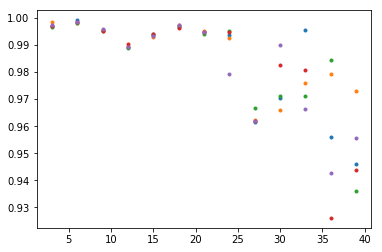

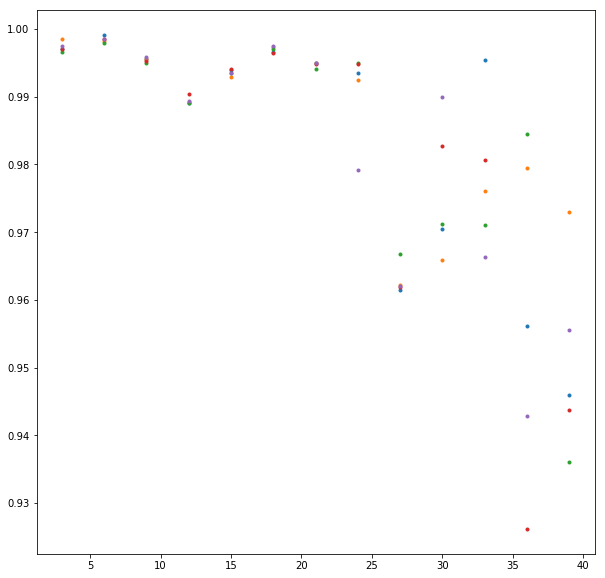

In [59]:
plt.plot(3*np.arange(1,14),R_coeffs,'.')
plt.figure(figsize=(10,10))
plt.show()

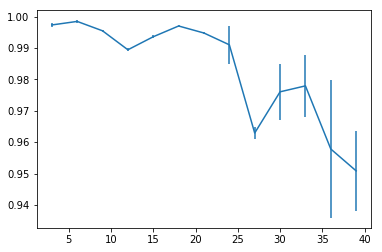

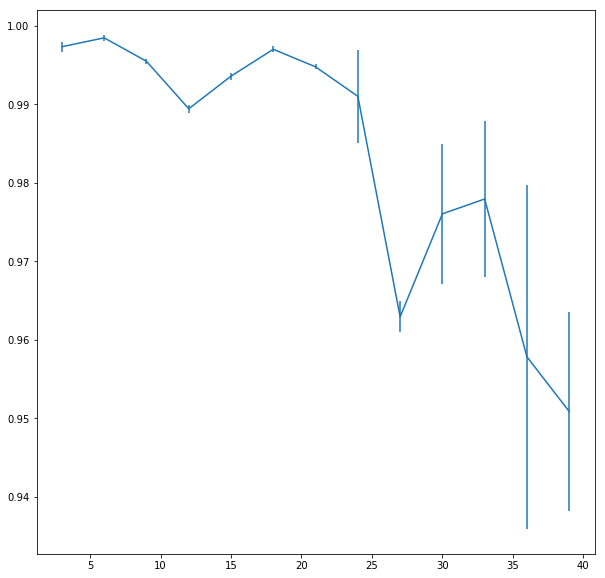

In [82]:
plt.errorbar(3*np.arange(1,14),np.mean(R_coeffs,axis=1),yerr = np.std(np.array(R_coeffs),axis = 1))
plt.figure(figsize=(10,10))
plt.show()

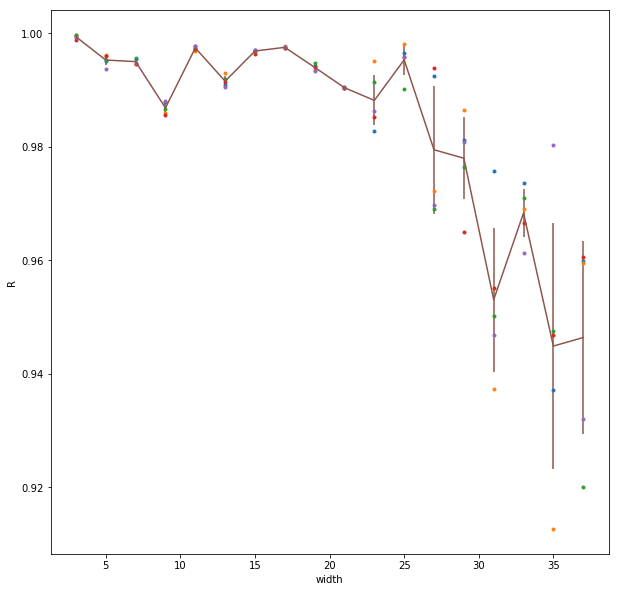

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(1+2*np.arange(1,19),R_coeffs,'.')
ax.errorbar(1+2*np.arange(1,19),np.mean(R_coeffs,axis=1),yerr = np.std(np.array(R_coeffs),axis = 1))
plt.xlabel('width')
plt.ylabel('R')
plt.show()


In [129]:
f= open("savevaluesfrom3to39step3.txt","w+")
f.write("with n_samples = 5, second parameter equal to 5 and width going from 3 to 39 with steps 3"+'\n')
for width in range(len(values_LPrelax)):
    f.write(str(width)+'\n')
    for test in range(len(values_LPrelax[0])):
        #f.write(str(values_LPrelax[width][test])+'\n')
        for val in values_LPrelax[width][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.close()

# Second study : noise impact, constant width 12

In [119]:
n_samples = 5

values_dijkstra2 = []
values_LPrelax2 = []
t0 = time.clock()

for noise in range(2,14):
    print(noise, ' runtime : ',time.clock() - t0)
    env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(12,noise*3))
    values_dijkstra2.append(dijkstra(env))
    tmp_LP2 = []
    for _ in range(n_samples):
        tmp_LP2.append(LPrelax(env))
    values_LPrelax2.append(tmp_LP2)

2  runtime :  0.00021589342486549867
False False False
False False False
False False False
False False False
False False False
3  runtime :  19.88935589945777
False False False
False False True
False False False
False False False
False False False
4  runtime :  40.560538692496266
False False False
False False False
False False True
False False True
False False True
5  runtime :  61.592179879329706
False False False
False False True
False False False
False False True
False False False
6  runtime :  86.4223843935506
False False False
False False False
False False False
False False False
False False False
7  runtime :  111.26937867493416
False False False
False False False
False False False
False False False
False False False
8  runtime :  127.39988113061554
False False False
False False True
False False False
False False False
False False False
9  runtime :  144.8314614747569
False False False
False False False
False False False
False False False
False False False
10  runtime :  166.3108

In [120]:
R_coeffs2 = np.zeros((len(values_LPrelax2),len(values_LPrelax2[0])))
for noise in range(len(values_LPrelax2)):
    v = values_dijkstra2[noise]
    for test in range(len(values_LPrelax2[noise])):
        R_coeffs2[noise][test] = scipy.stats.pearsonr(values_LPrelax2[noise][test],v)[0]

In [130]:
f= open("savevaluesnoisefrom6to39step3.txt","w+")
f.write("with n_samples = 5, second parameter equal to 5 and noise going from 6 to 39 with steps 3"+'\n')
for width in range(len(values_LPrelax2)):
    f.write(str(width)+'\n')
    for test in range(len(values_LPrelax2[0])):
        #f.write(str(values_LPrelax2[width][test])+'\n')
        for val in values_LPrelax2[width][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.close()

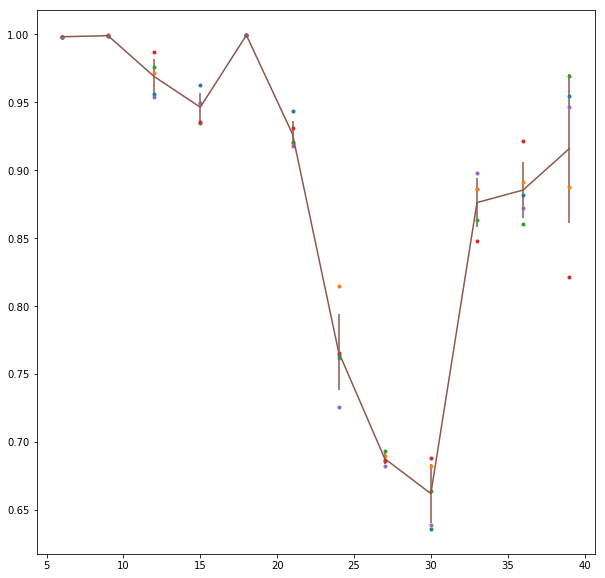

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(3*np.arange(2,14),R_coeffs2,'.')
ax.errorbar(3*np.arange(2,14),np.mean(R_coeffs2,axis=1),yerr = np.std(np.array(R_coeffs2),axis = 1))
plt.show()

In [114]:
values_LPrelax2[0][0]

array([89.65311879, 87.64768896, 86.43605777, ..., 80.91507763,
       82.29641757, 92.2830874 ])

# Third study : width impact, step 1, noise 12

In [125]:
#env = GridWorld(gamma=0.95, grid=generate_a_grid(20,2))
env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(10,5))

n_samples = 5

values_dijkstra3 = []
values_LPrelax3 = []
t0 = time.clock()

for width in range(3,40):
    print(width, ' runtime : ',time.clock() - t0)
    env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(width,12))
    values_dijkstra3.append(dijkstra(env))
    tmp_LP3 = []
    for _ in range(n_samples):
        tmp_LP3.append(LPrelax(env))
    values_LPrelax3.append(tmp_LP3)

3  runtime :  0.00010837338049896061
False False False
False False False
False False False
False False False
False False False
4  runtime :  0.3417622791530448
False False False
False False False
False False False
False False False
False False False
5  runtime :  1.3391711313797714
False False False
False False False
False False False
False False False
False False False
6  runtime :  3.364226715404584
False False False
False False False
False False False
False False False
False False False
7  runtime :  6.19301170901781
False False False
False False False
False False False
False False False
False False False
8  runtime :  10.277277131637675
False False False
False False False
False False False
False False False
False False False
9  runtime :  16.77754401175298
False False True
False False False
False False False
False False False
False False True
10  runtime :  27.417335644729974
False False False
False False False
False False False
False False False
False False False
11  runtime :  40

In [131]:
f= open("savevaluesfrom3to39.txt","w+")
f.write("with n_samples = 5, second parameter equal to 12 and width going from 3 to 39 with steps 1"+'\n')
for width in range(len(values_LPrelax3)):
    f.write(str(width+3)+'\n')
    for test in range(len(values_LPrelax3[0])):
        #f.write(str(values_LPrelax3[width][test])+'\n')
        for val in values_LPrelax3[width][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.close()

In [132]:
R_coeffs3 = np.zeros((len(values_LPrelax3),len(values_LPrelax3[0])))
for width in range(len(values_LPrelax3)):
    v = values_dijkstra3[width]
    for test in range(len(values_LPrelax3[width])):
        R_coeffs3[width][test] = scipy.stats.pearsonr(values_LPrelax3[width][test],v)[0]

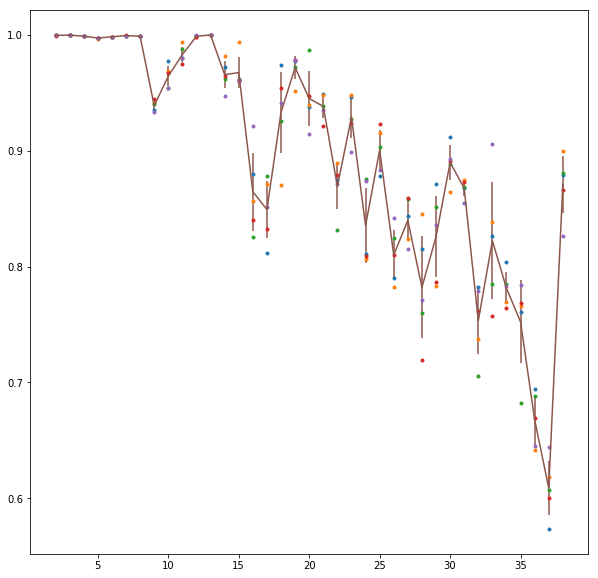

In [133]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(2,39),R_coeffs3,'.')
ax.errorbar(np.arange(2,39),np.mean(R_coeffs3,axis=1),yerr = np.std(np.array(R_coeffs3),axis = 1))
plt.show()

# Fifth study : noise impact, step 1, width 9

In [139]:
n_samples = 5

values_dijkstra5 = []
values_LPrelax5 = []
t0 = time.clock()

for noise in range(2,40):
    print(noise, ' runtime : ',time.clock() - t0)
    tmp_LP5, tmp_v5 = [], []
    for _ in range(n_samples):
        env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(9,noise))
        tmp_v5.append(dijkstra(env))
        tmp_LP5.append(LPrelax(env))
    values_dijkstra5.append(tmp_v5)
    values_LPrelax5.append(tmp_LP5)

36  runtime :  0.0003989335054939147
False False False
False False True
False False False
False False True
False False True
36  runtime :  7.167100231297809
False False False
False False False
False False False
False False True
False False True
36  runtime :  14.214942385042377
False False False
False False True
False False True
False False False
False False False
36  runtime :  23.95583272782096
False False False
False False False
False False False
False False True
False False True
36  runtime :  34.403643478886806
False False False
False False False
False False False
False False False
False False True
36  runtime :  45.44746813758684
False False False
False False False
False False False
False False False
False False False
36  runtime :  55.901556011333014
False False False
False False False
False False True
False False False
False False False
36  runtime :  66.30709559769457
False False False
False False False
False False False
False False False
False False False
36  runtime :  76.31

In [140]:
f= open("savevaluesnoisefrom2to39step1differentenvs.txt","w+")
f.write("with n_samples = 5, width of 9 and noise going from 2 to 39 with steps 1"+'\n')
for noise in range(len(values_LPrelax5)):
    f.write(str(noise+2)+'\n')
    for test in range(len(values_LPrelax5[0])):
        #f.write(str(values_LPrelax3[width][test])+'\n')
        for val in values_LPrelax5[noise][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.write('----now for dijkstra----')
for noise in range(len(values_dijkstra5)):
    f.write(str(noise+3)+'\n')
    for test in range(len(values_dijkstra5[0])):
        #f.write(str(values_dijkstra4[noise][test])+'\n')
        for val in values_dijkstra5[noise][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.close()

In [141]:
R_coeffs5 = np.zeros((len(values_LPrelax5),len(values_LPrelax5[0])))
for noise in range(len(values_LPrelax5)):
    for test in range(len(values_LPrelax5[width])):
        R_coeffs5[noise][test] = scipy.stats.pearsonr(values_LPrelax5[noise][test],values_dijkstra5[noise][test])[0]

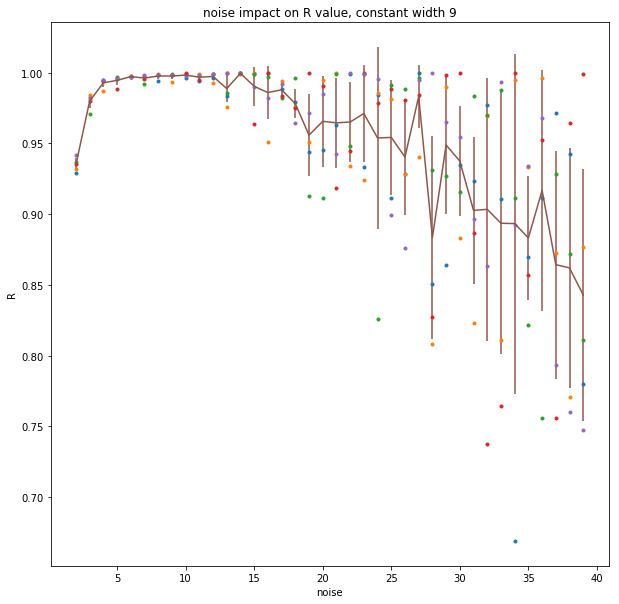

In [152]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(2,40),R_coeffs5,'.')
ax.errorbar(np.arange(2,40),np.mean(R_coeffs5,axis=1),yerr = np.std(np.array(R_coeffs5),axis = 1))
plt.xlabel('noise')
plt.ylabel('R')
plt.title('noise impact on R value, constant width 9')
plt.show()

# Fourth study : width impact, step 1, noise 12

In [145]:
n_samples = 5

values_dijkstra4 = []
values_LPrelax4 = []
t0 = time.clock()

for width in range(3,40):
    print(width, ' runtime : ',time.clock() - t0)
    tmp_LP4, tmp_v4 = [], []
    for _ in range(n_samples):
        env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(width,12))
        tmp_v4.append(dijkstra(env))
        tmp_LP4.append(LPrelax(env))
    values_dijkstra4.append(tmp_v4)
    values_LPrelax4.append(tmp_LP4)

3  runtime :  0.00012629338380065747
False False False
False False False
False False False
False False False
False False False
4  runtime :  0.38032400226802565
False False False
False False False
False False False
False False False
False False False
5  runtime :  1.2616837383175152
False False False
False False False
False False False
False False False
False False False
6  runtime :  3.0830912354504107
False False False
False False False
False False False
False False False
False False False
7  runtime :  6.160687001891347
False False False
False False False
False False False
False False False
False False False
8  runtime :  11.458077208779287
False False False
False False False
False False False
False False False
False False False
9  runtime :  17.594422013618896
False False True
False False True
False False False
False False False
False False False
10  runtime :  27.476757536747755
False False False
False False False
False False False
False False False
False False False
11  runtime :

In [146]:
f= open("savevaluesfrom3to39step1differentenvs.txt","w+")
f.write("with n_samples = 5, second parameter equal to 12 and width going from 3 to 39 with steps 1"+'\n')
for width in range(len(values_LPrelax4)):
    f.write(str(width+3)+'\n')
    for test in range(len(values_LPrelax4[0])):
        #f.write(str(values_LPrelax3[width][test])+'\n')
        for val in values_LPrelax4[width][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.write('----now for dijkstra----')
for width in range(len(values_dijkstra4)):
    f.write(str(width+3)+'\n')
    for test in range(len(values_dijkstra4[0])):
        #f.write(str(values_dijkstra4[width][test])+'\n')
        for val in values_dijkstra4[width][test]:
            f.write(str(val)+' ')
        f.write('\n')
f.close()

In [147]:
R_coeffs4 = np.zeros((len(values_LPrelax4),len(values_LPrelax4[0])))
for width in range(len(values_LPrelax4)):
    for test in range(len(values_LPrelax4[width])):
        R_coeffs4[width][test] = scipy.stats.pearsonr(values_LPrelax4[width][test],values_dijkstra4[width][test])[0]

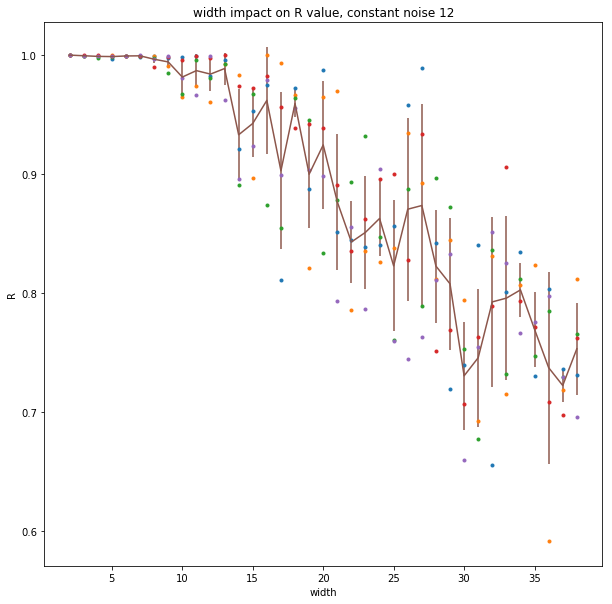

In [151]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(2,39),R_coeffs4,'.')
ax.errorbar(np.arange(2,39),np.mean(R_coeffs4,axis=1),yerr = np.std(np.array(R_coeffs4),axis = 1))
plt.xlabel('width')
plt.ylabel('R')
plt.title('width impact on R value, constant noise 12')
plt.show()

# Sixth study : combined impacts

In [35]:
n_samples = 5

values_Rcoeffs = np.zeros((n_samples,13,13))
t0 = time.clock()
    
for width in range(0,13):
    for noise in range(0,13):
        print('width : ',3+width*2, ' noise : ', 2+noise*2, ' runtime : ',time.clock() - t0)
        for level in range(n_samples):
            env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(3+width*2,2+noise*2))
            values_Rcoeffs[level][width][noise] = scipy.stats.pearsonr(LPrelax(env),dijkstra(env))[0]

width :  3  noise :  2  runtime :  0.00016682666682754643
width :  3  noise :  4  runtime :  0.36415701333316974
width :  3  noise :  6  runtime :  0.6855150933333789
width :  3  noise :  8  runtime :  0.9883716266667761
width :  3  noise :  10  runtime :  1.3172654933332524
width :  3  noise :  12  runtime :  1.654347946667258
width :  3  noise :  14  runtime :  1.9686067200018442
width :  3  noise :  16  runtime :  2.2727291733353923
width :  3  noise :  18  runtime :  2.5987490133338724
width :  3  noise :  20  runtime :  2.9030417066678638
width :  3  noise :  22  runtime :  3.2094681599992327
width :  3  noise :  24  runtime :  3.5236753066674282
width :  3  noise :  26  runtime :  3.812247040001239
width :  5  noise :  2  runtime :  4.13811712000097
width :  5  noise :  4  runtime :  5.80915584000104
width :  5  noise :  6  runtime :  7.534420480002154
width :  5  noise :  8  runtime :  9.237504426666419
width :  5  noise :  10  runtime :  10.947508053333877
width :  5  noise :  

width :  25  noise :  16  runtime :  5093.800228266668
width :  25  noise :  18  runtime :  5176.807284053335
width :  25  noise :  20  runtime :  5266.800647253334
width :  25  noise :  22  runtime :  5378.2929049600025
width :  25  noise :  24  runtime :  5490.89192192
width :  25  noise :  26  runtime :  5603.106099626668
width :  27  noise :  2  runtime :  5715.096494506666
width :  27  noise :  4  runtime :  5905.781448106667
width :  27  noise :  6  runtime :  6066.07831936
width :  27  noise :  8  runtime :  6216.969407573335
width :  27  noise :  10  runtime :  6367.683706453336
width :  27  noise :  12  runtime :  6513.958936746669
width :  27  noise :  14  runtime :  6655.383609173336
width :  27  noise :  16  runtime :  6794.740942506669
width :  27  noise :  18  runtime :  6940.867831039999
width :  27  noise :  20  runtime :  7081.914275840001
width :  27  noise :  22  runtime :  7227.024459093333
width :  27  noise :  24  runtime :  7361.936485120001
width :  27  noise : 

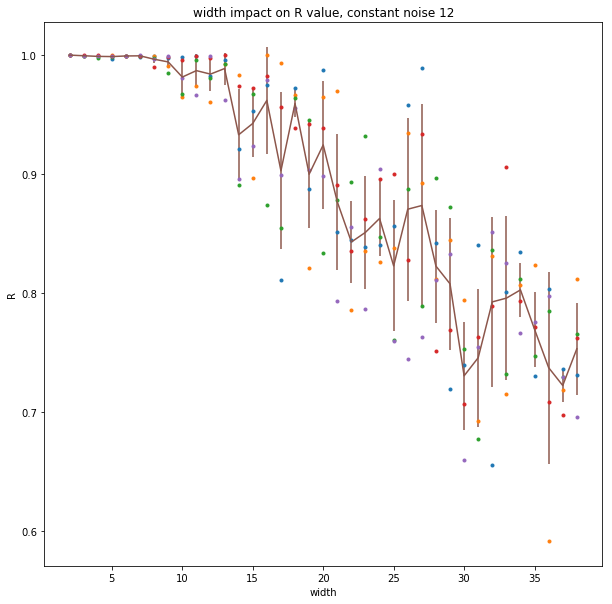

In [159]:
values_Rcoeffs2 = values_Rcoeffs

In [38]:
f= open("saveRcoeffsPLZ.txt","w+")
for width in range(0,13):
    for noise in range(0,13):
        for sample in range(5):
            f.write(str(values_Rcoeffs[sample][width][noise])+' ')
    f.write('\n')
f.close()

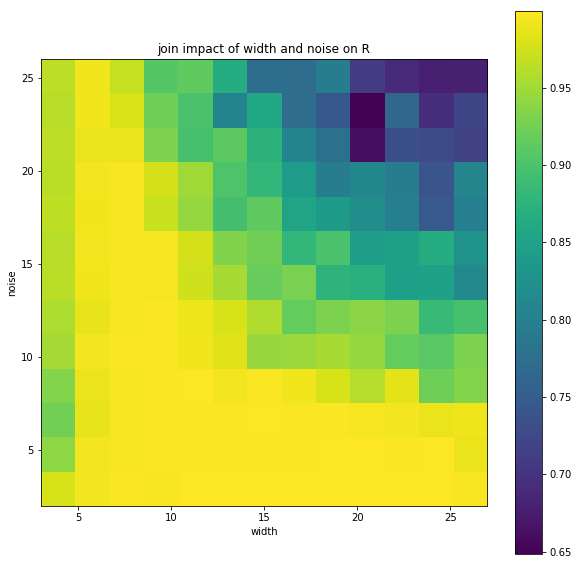

In [39]:
Rmean = np.mean(values_Rcoeffs, axis = 0)
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(Rmean, origin = 'lower', extent=[3,27,2,26])
plt.xlabel('width')
plt.ylabel('noise')
plt.title('join impact of width and noise on R')
plt.colorbar()
plt.show()

# Seventh study : sampling influence

In [58]:
n_samples = 10

values_Rcoeffs7 = np.zeros((n_samples,5))
t0 = time.clock()

for ns in range(n_samples):
    env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(9,18))
    m = dijkstra(env)
    for sampler_exp in range(5):
        print(sampler_exp, -t0 + time.clock())
        v = LPrelax(env, 10**sampler_exp)
        values_Rcoeffs7[ns][sampler_exp] = scipy.stats.pearsonr(v,m)[0]

0 0.007783680004649796
1 0.047161599999526516
2 0.11665493332839105
3 0.34740949333354365
4 1.7818427733291173
0 15.349146026666858
1 15.387394986668369
2 15.436812373329303
3 15.633226239995565
4 17.055596373334993
0 32.40201685333159
1 32.44253440000466
2 32.50505429333134
3 32.85644885333022
4 34.84905386666651
0 52.21510954666883
1 52.250415786664234
2 52.315457279997645
3 52.70144341333071
4 54.64871338667581
0 73.77919616000145
1 73.81270058666996
2 73.87983104000159
3 74.19417813332984
4 76.4462476799963
0 95.62991061333742
1 95.66649344000325
2 95.73665664000146
3 96.05872469332826
4 98.07618560000265
0 113.71168213333294
1 113.74085034667223
2 113.79485525333439
3 114.03482112000347
4 115.58516778667399
0 131.33606954666902
1 131.36639999999898
2 131.42577194666956
3 131.6477990400017
4 133.33262080000713
0 149.23538602667395
1 149.26370559999486
2 149.31545002666826
3 149.53698474666453
4 151.2576853333303
0 166.33504469333275
1 166.36028757333406
2 166.4093700266676
3 166.66

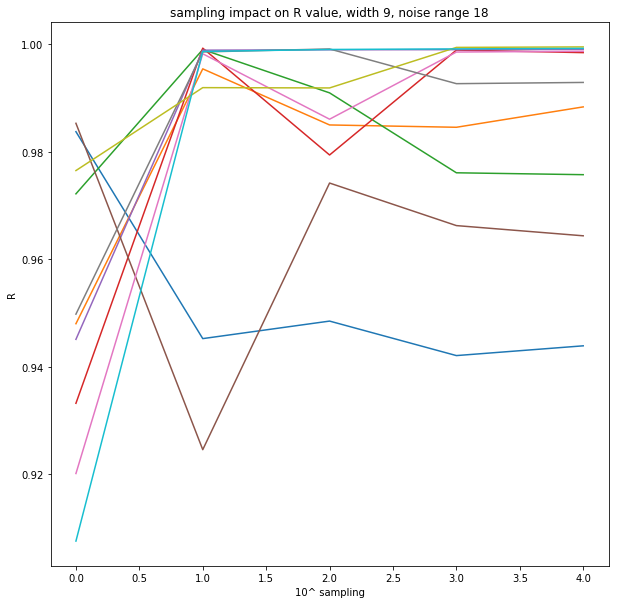

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(0,5),values_Rcoeffs7.T)
plt.xlabel('10^ sampling')
plt.ylabel('R')
plt.title('sampling impact on R value, width 9, noise range 18')
plt.show()

In [64]:
n_samples = 30

values_Rcoeffs7b = np.zeros((n_samples,5))
t0 = time.clock()

for ns in range(n_samples):
    env = GridWorld(gamma=0.95, grid=generate_a_grid_withwalls(5,5))
    m = dijkstra(env)
    for sampler_exp in range(5):
        print(sampler_exp, -t0 + time.clock())
        v = LPrelax(env, 10**sampler_exp)
        values_Rcoeffs7b[ns][sampler_exp] = scipy.stats.pearsonr(v,m)[0]

0 0.0030097066628513858
1 0.013690026666154154
2 0.02793813332391437
3 0.07591210666578263
4 0.500920746664633
0 3.8281915733241476
1 3.837650773333735
2 3.8532915199903073
3 3.897551359987119
4 4.270696533320006
0 7.761626026665908
1 7.770869759988273
2 7.786175573332002
3 7.833900373327197
4 8.228568746664678
0 12.718088959998568
1 12.730226773332106
2 12.746227626659675
3 12.802346666663652
4 13.269216853324906
0 17.877131093322532
1 17.8885043199989
2 17.90763050665555
3 17.969983146656887
4 18.474545066666906
0 23.068416853333474
1 23.07861631999549
2 23.099770026659826
3 23.15911637332465
4 23.615802879998228
0 28.36780629333225
1 28.3789222399937
2 28.396724906662712
3 28.46197589332587
4 28.94728021332412
0 33.773309439988225
1 33.786618453334086
2 33.80327893332287
3 33.85992191999685
4 34.354795946666854
0 38.94191573333228
1 38.95068373333197
2 38.9667187199957
3 39.024971519989776
4 39.489164373328094
0 44.15138517333253
1 44.16263039999467
2 44.184333226658055
3 44.2455530

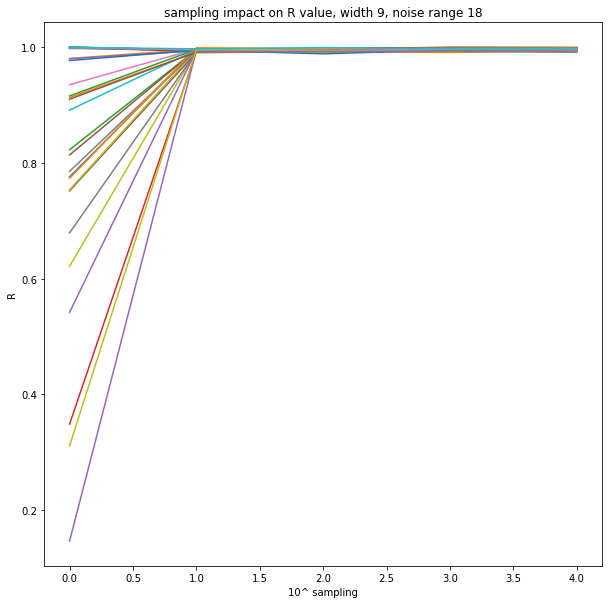

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(0,5),values_Rcoeffs7b.T)
plt.xlabel('10^ sampling')
plt.ylabel('R')
plt.title('sampling impact on R value, width 9, noise range 18')
plt.show()